# TGFB3
Pathogenic variants in TGFB3 are associated with both 
[Arrhythmogenic right ventricular dysplasia 1 (OMIM:107970)](https://omim.org/entry/107970)	and
[Loeys-Dietz syndrome 5	(OMIM:615582)](https://omim.org/entry/615582).

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.2


### TGFB3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFB3.

In [2]:
gene_symbol = 'TGFB3'
mane_tx_id = 'NM_003239.5'
mane_protein_id = 'NP_003230.1' # transforming growth factor beta-3 proprotein isoform 1 preproprotein [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 75/75 [00:28<00:00,  2.64 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
28,Aortic root aneurysm
23,Tall stature
23,Hypertelorism
16,Arachnodactyly
16,Retrognathia
15,Scoliosis
12,Mitral valve prolapse
12,Bifid uvula
11,Long face
10,Cleft palate


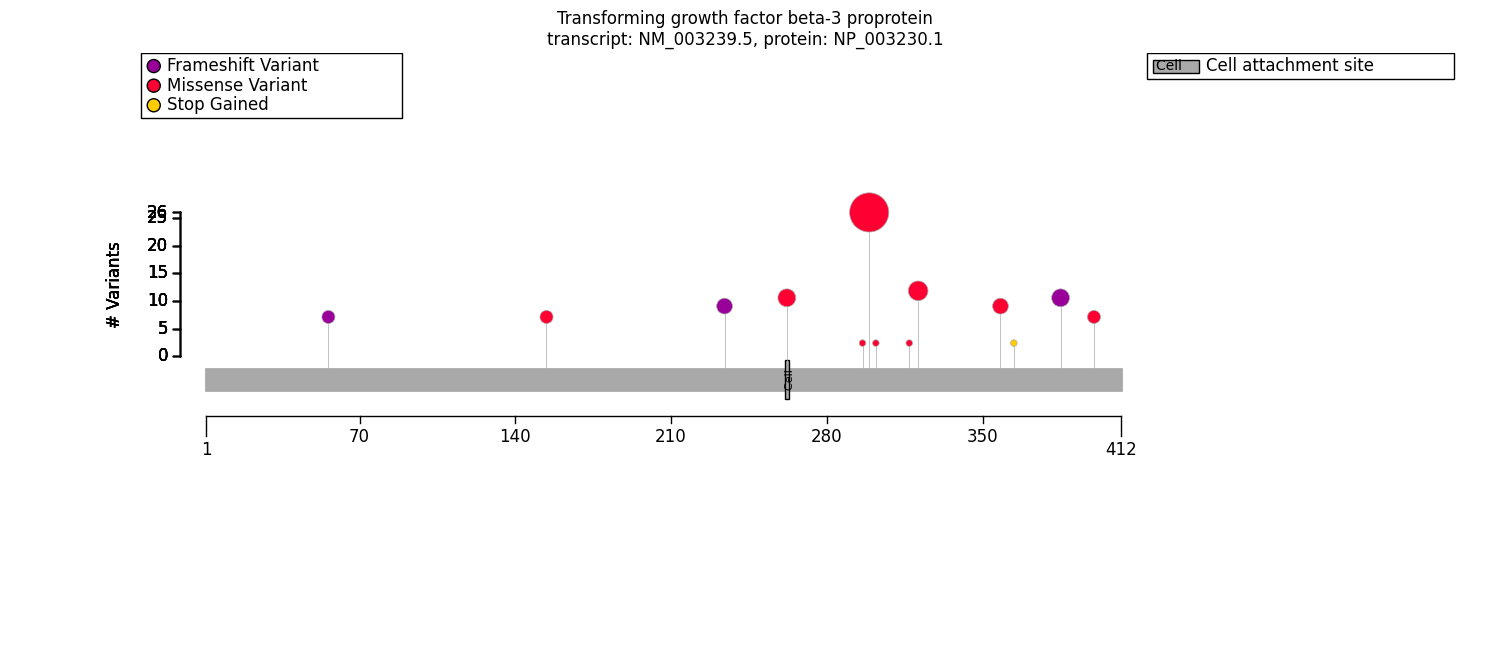

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

tgfb3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tgfb3_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
4,Cell attachment site,Motif,262 - 263,p.Asp263His


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [10]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier

asp263his = variant_key(key="14_75963455_75963455_C_G") # c.787G>C; p.Asp263His

asp263his_clf = monoallelic_classifier(
    a_predicate=asp263his,
    b_predicate=~asp263his,
    a_label="Asp263His",
    b_label="Other"
)

asp263his_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=asp263his_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(asp263his_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,56
HMF03,Skipping term because of a child term with the same individual counts,1
HMF05,Skipping term because one genotype had zero observations,2
HMF08,Skipping general term,60
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,130


In [11]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=asp263his_result)

Allele group                                       Asp263His          Other  \
                                                       Count Percent  Count   
Dolichocephaly [HP:0000268]                              1/1    100%   7/33   
Aortic root aneurysm [HP:0002616]                        3/4     75%  25/54   
Retrognathia [HP:0000278]                                1/1    100%  15/40   
Abnormal systemic arterial morphology [HP:0011004]       3/3    100%  33/33   
Abnormal blood vessel morphology [HP:0033353]            3/3    100%  36/36   
Vascular dilatation [HP:0002617]                         3/3    100%  30/30   
Abnormal axial skeleton morphology [HP:0009121]          1/1    100%  32/32   
Thoracic aortic aneurysm [HP:0012727]                    3/3    100%  28/28   
Aortic aneurysm [HP:0004942]                             3/3    100%  29/29   
Abnormal aortic morphology [HP:0001679]                  3/3    100%  30/30   

Allele group                                                                   \
                                                   Percent Corrected p values   
Dolichocephaly [HP:0000268]                            21%                1.0   
Aortic root aneurysm [HP:0002616]                      46%                1.0   
Retrognathia [HP:0000278]                              38%                1.0   
Abnormal systemic arterial morphology [HP:0011004]    100%                1.0   
Abnormal blood vessel morphology [HP:0033353]         100%                1.0   
Vascular dilatation [HP:0002617]                      100%                1.0   
Abnormal axial skeleton morphology [HP:0009121]       100%                1.0   
Thoracic aortic aneurysm [HP:0012727]                 100%                1.0   
Aortic aneurysm [HP:0004942]                          100%                1.0   
Abnormal aortic morphology [HP:0001679]               100%                1.0   

Allele group                                                  
                                                    p values  
Dolichocephaly [HP:0000268]                         0.235294  
Aortic root aneurysm [HP:0002616]                   0.344498  
Retrognathia [HP:0000278]                           0.390244  
Abnormal systemic arterial morphology [HP:0011004]  1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000  
Vascular dilatation [HP:0002617]                    1.000000  
Abnormal axial skeleton morphology [HP:0009121]     1.000000  
Thoracic aortic aneurysm [HP:0012727]               1.000000  
Aortic aneurysm [HP:0004942]                        1.000000  
Abnormal aortic morphology [HP:0001679]             1.000000

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Varicose veins [HP:0002619]                            3/22     14%   6/12   
Aortic root aneurysm [HP:0002616]                     15/38     39%  13/20   
Retrognathia [HP:0000278]                              9/28     32%   7/13   
Tall stature [HP:0000098]                             13/33     39%  10/22   
Abnormal systemic arterial morphology [HP:0011004]    17/17    100%  19/19   
Abnormal blood vessel morphology [HP:0033353]         18/18    100%  21/21   
Vascular dilatation [HP:0002617]                      17/17    100%  16/16   
Abnormal axial skeleton morphology [HP:0009121]       23/23    100%  10/10   
Thoracic aortic aneurysm [HP:0012727]                 16/16    100%  15/15   
Aortic aneurysm [HP:0004942]                          16/16    100%  16/16   
Abnormal aortic morphology [HP:0001679]               16/16    100%  17/17   
Hypertelorism [HP:0000316]                            18/37     49%   5/11   

Allele group                                                                   \
                                                   Percent Corrected p values   
Varicose veins [HP:0002619]                            50%           0.483750   
Aortic root aneurysm [HP:0002616]                      65%           0.583817   
Retrognathia [HP:0000278]                              54%           1.000000   
Tall stature [HP:0000098]                              45%           1.000000   
Abnormal systemic arterial morphology [HP:0011004]    100%           1.000000   
Abnormal blood vessel morphology [HP:0033353]         100%           1.000000   
Vascular dilatation [HP:0002617]                      100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Thoracic aortic aneurysm [HP:0012727]                 100%           1.000000   
Aortic aneurysm [HP:0004942]                          100%           1.000000   
Abnormal aortic morphology [HP:0001679]               100%           1.000000   
Hypertelorism [HP:0000316]                             45%           1.000000   

Allele group                                                  
                                                    p values  
Varicose veins [HP:0002619]                         0.040313  
Aortic root aneurysm [HP:0002616]                   0.097303  
Retrognathia [HP:0000278]                           0.302388  
Tall stature [HP:0000098]                           0.781782  
Abnormal systemic arterial morphology [HP:0011004]  1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000  
Vascular dilatation [HP:0002617]                    1.000000  
Abnormal axial skeleton morphology [HP:0009121]     1.000000  
Thoracic aortic aneurysm [HP:0012727]               1.000000  
Aortic aneurysm [HP:0004942]                        1.000000  
Abnormal aortic morphology [HP:0001679]             1.000000  
Hypertelorism [HP:0000316]                          1.000000

In [13]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Dolichocephaly [HP:0000268]                          0/14      0%   8/20   
Aortic root aneurysm [HP:0002616]                    8/26     31%  20/32   
Tall stature [HP:0000098]                            7/25     28%  16/30   
Hypertelorism [HP:0000316]                          12/21     57%  11/27   
Long face [HP:0000276]                               6/15     40%   5/20   
Retrognathia [HP:0000278]                            7/16     44%   9/25   
Abnormal systemic arterial morphology [HP:0011004]  12/12    100%  24/24   
Abnormal blood vessel morphology [HP:0033353]       13/13    100%  26/26   
Vascular dilatation [HP:0002617]                    10/10    100%  23/23   
Abnormal axial skeleton morphology [HP:0009121]     12/12    100%  21/21   
Thoracic aortic aneurysm [HP:0012727]                 9/9    100%  22/22   
Aortic aneurysm [HP:0004942]                        10/10    100%  22/22   
Abnormal aortic morphology [HP:0001679]             10/10    100%  23/23   

Sex                                                                            \
                                                   Percent Corrected p values   
Dolichocephaly [HP:0000268]                            40%           0.128900   
Aortic root aneurysm [HP:0002616]                      62%           0.128900   
Tall stature [HP:0000098]                              53%           0.427783   
Hypertelorism [HP:0000316]                             41%           1.000000   
Long face [HP:0000276]                                 25%           1.000000   
Retrognathia [HP:0000278]                              36%           1.000000   
Abnormal systemic arterial morphology [HP:0011004]    100%           1.000000   
Abnormal blood vessel morphology [HP:0033353]         100%           1.000000   
Vascular dilatation [HP:0002617]                      100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Thoracic aortic aneurysm [HP:0012727]                 100%           1.000000   
Aortic aneurysm [HP:0004942]                          100%           1.000000   
Abnormal aortic morphology [HP:0001679]               100%           1.000000   

Sex                                                           
                                                    p values  
Dolichocephaly [HP:0000268]                         0.010884  
Aortic root aneurysm [HP:0002616]                   0.019831  
Tall stature [HP:0000098]                           0.098719  
Hypertelorism [HP:0000316]                          0.382959  
Long face [HP:0000276]                              0.467408  
Retrognathia [HP:0000278]                           0.746053  
Abnormal systemic arterial morphology [HP:0011004]  1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000  
Vascular dilatation [HP:0002617]                    1.000000  
Abnormal axial skeleton morphology [HP:0009121]     1.000000  
Thoracic aortic aneurysm [HP:0012727]               1.000000  
Aortic aneurysm [HP:0004942]                        1.000000  
Abnormal aortic morphology [HP:0001679]             1.000000

# Summary
We found no evidence for genotype-phenotype correlations.

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=asp263his_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant correlations identified."

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,12,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Asp263His,Other,10,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,13,0


In [16]:
summarizer.process_latex(report=report, protein_fig=tgfb3_fig)

Figure saved to ../../supplement/img/TGFB3_protein_diagram-draft.pdf
Output to ../../supplement/tex/TGFB3_summary_draft.tex
